In [ ]:
import pandas as pd

data = pd.read_csv("products_fixed.csv")

data['sugar_intake'] = data['sugar_intake'].str.replace(',', '.').astype(float)
data = data.dropna()

print("Full Dataset:")
print(data)

def show_data_by_category(data):
    categories = data['category'].unique()
    for category in categories:
        print(f"\nData for Category: {category}")
        filtered_data = data[data['category'] == category]
        print(filtered_data)

print("\nDataset Grouped by Categories:")
show_data_by_category(data)

Full Dataset:
        product_id                                       product_name  \
0    9556156046108     Yeo's Minuman Jeli Sarang Burung Kaleng 300 ml   
1    8997035601482                             Fibe Mini Botol 100 ml   
2    8998009020186             Buavita Minuman Sari Buah Jambu 245 mL   
3    8994947000273  ITO EN Oi Ocha Minuman Teh Hijau Tanpa Gula Ho...   
4    8998888150455                SUNQUICK Jus Sari Buah Lemon 330 ml   
..             ...                                                ...   
364  8859112600064  ITO EN Minuman Teh Hijau Melati Tanpa Gula Bot...   
365  8992761122324       Frestea Minuman Teh Rasa Melati Botol 500 ml   
366    89686827286         Cocobit Minuman Splash Mangga Botol 350 ml   
367  8801128945462              Pororo Minuman Rasa Apel Botol 235 ml   
368  8995227500377          Cap Panda Minuman Liang Teh Kaleng 310 ml   

              category  sugar_intake  
0    Minuman Kesehatan          25.0  
1    Minuman Kesehatan         

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.5086 - mae: 0.1411 - val_loss: 1.8343 - val_mae: 0.0805
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6747 - mae: 0.0967 - val_loss: 1.1944 - val_mae: 0.0743
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0833 - mae: 0.0876 - val_loss: 0.7638 - val_mae: 0.0781
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6999 - mae: 0.0936 - val_loss: 0.4836 - val_mae: 0.0790
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4430 - mae: 0.0920 - val_loss: 0.3049 - val_mae: 0.0802
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2814 - mae: 0.0903 - val_loss: 0.1930 - val_mae: 0.0830
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━

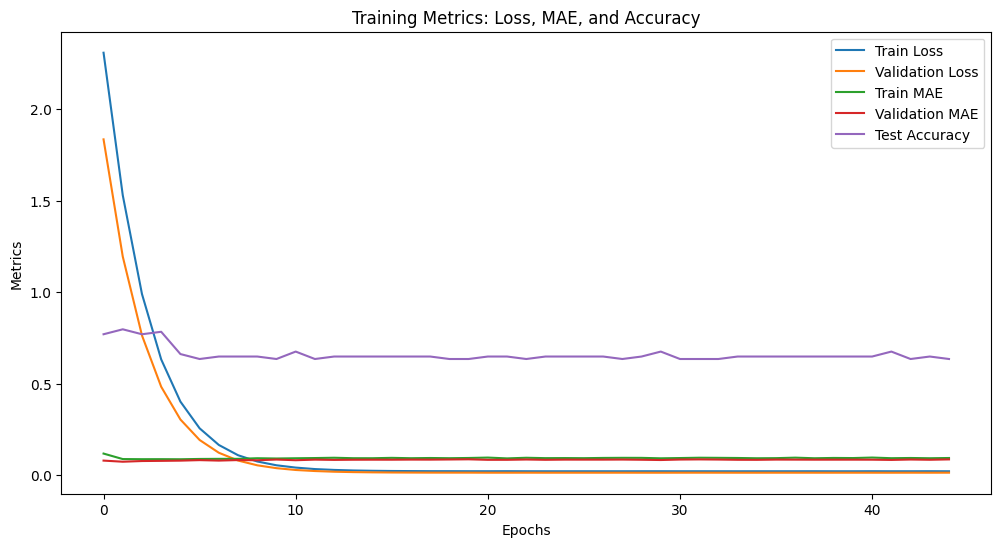

\Model Berhasil Disimpan Pada Local Runtime dengan Nama : 'new_model.h5'
\Silahkan Download Model Agar Tersimpan Permanen di Local Drive


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("products_fixed.csv")
data['sugar_intake'] = data['sugar_intake'].str.replace(',', '.').astype(float)
data = data.dropna()

scaler = MinMaxScaler()
data['normalized_sugar_intake'] = scaler.fit_transform(data[['sugar_intake']])

def create_category_embeddings(categories):
    vocabulary = sorted(list(set(categories)))
    cat_to_idx = {cat: idx for idx, cat in enumerate(vocabulary)}

    num_categories = len(vocabulary)
    one_hot = np.zeros((len(categories), num_categories))
    for i, cat in enumerate(categories):
        one_hot[i, cat_to_idx[cat]] = 1

    return one_hot, vocabulary

categories, _ = create_category_embeddings(data['category'])

X_train, X_test, y_train, y_test = train_test_split(categories, data['normalized_sugar_intake'], test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='linear')  # Output layer
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
)

accuracy_history = []
def custom_callback(epoch, logs):
    y_pred = model.predict(X_test)
    acc = np.mean(np.abs(y_test - y_pred.squeeze()) < 0.1)  # Accuracy threshold
    accuracy_history.append(acc)

callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=custom_callback)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, callback],
    verbose=1
)

loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Loss (MSE): {loss:.4f}")
print(f"Final Test Mean Absolute Error (MAE): {mae:.4f}")
print(f"Final Test Accuracy: {accuracy_history[-1]:.4f}")

plt.figure(figsize=(12, 6))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')

plt.plot(accuracy_history, label='Test Accuracy')

plt.title('Training Metrics: Loss, MAE, and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

# Saved Model
model.save('low_sugar_recommender_model.h5')
print("\Model Berhasil Disimpan Pada Local Runtime dengan Nama : 'low_sugar_recommender_model.h5'")
print("\Silahkan Download Model Agar Tersimpan Permanen di Local Drive")

In [ ]:
def recommend_low_sugar_tf(data, category, n=5, sugar_threshold=20):
    category_data = data[(data['category'] == category) & (data['sugar_intake'] < sugar_threshold)]
    if category_data.empty:
        return pd.DataFrame()

    category_data = category_data[['product_id', 'product_name', 'category', 'sugar_intake']].head(n)
    category_data['sugar_intake'] = category_data['sugar_intake']
    return category_data

unique_categories = data['category'].unique()
print("\nTop 5 Low-Sugar Products for Each Category:")
for category in unique_categories:
    print(f"\nCategory: {category}")
    recommendations = recommend_low_sugar_tf(data, category, n=5, sugar_threshold=20)
    if not recommendations.empty:
        print(recommendations)
    else:
        print("No low-sugar products found for this category.")



Top 5 Low-Sugar Products for Each Category:

Category: Minuman Kesehatan
       product_id                                       product_name  \
1   8997035601482                             Fibe Mini Botol 100 ml   
16   749921021106  Tropicana Slim Collagen Shot Minuman Tinggi Se...   
18   792649436547       100PLUS Active Minuman Isotonik Botol 350 ml   
21  8991102028158   Panjang Jiwo Larutan Penyegar Melon Botol 350 ml   
34  8992994110112                     Yakult Minuman Probiotik 5 pcs   

             category  sugar_intake  
1   Minuman Kesehatan           9.0  
16  Minuman Kesehatan           6.0  
18  Minuman Kesehatan          19.0  
21  Minuman Kesehatan           8.0  
34  Minuman Kesehatan          10.0  

Category: Jus & Sari Buah
        product_id                                       product_name  \
11    711844162419               ABC Minuman Sari Kacang Hijau 250 ml   
23   8997222540167                            Toza Jus Buah Jambu 1 L   
87   8998866202923 

In [ ]:
def recommend_based_on_product_id(data, product_id, sugar_threshold=20, n=5):
    if product_id not in data['product_id'].values:
        print(f"Error: Product ID '{product_id}' not found in the dataset.")
        return

    product_info = data[data['product_id'] == product_id].iloc[0]
    category = product_info['category']
    print("\nProduct Found:")
    print(product_info[['product_id', 'product_name', 'category', 'sugar_intake']])

    # Filter Produk Berdasarkan Kategori Yang Sama dan sugar_intake Yang Lebih Rendah dari Threshold
    recommended_products = data[
        (data['category'] == category) &
        (data['sugar_intake'] < sugar_threshold) &
        (data['product_id'] != product_id)
    ].sort_values(by='sugar_intake', ascending=True).head(n)

    if recommended_products.empty:
        print("\nNo low-sugar products found in the same category.")
    else:
        print(f"\nTop {n} Low-Sugar Product Recommendations in Category '{category}':")
        print(recommended_products[['product_id', 'product_name', 'category', 'sugar_intake']])

try:
    input_product_id = int(input("\nEnter the Product ID to get recommendations: "))
    recommend_based_on_product_id(data, product_id=input_product_id, sugar_threshold=20, n=6)
except ValueError:
    print("Invalid input! Please enter a valid numeric Product ID.")


Enter the Product ID to get recommendations: 8850389108062

Product Found:
product_id                                        8850389108062
product_name    Mogu Mogu Minuman Nata De Coco Rasa Leci 320 ml
category                                   Sari Kelapa & Cincau
sugar_intake                                               35.0
Name: 130, dtype: object

Top 6 Low-Sugar Product Recommendations in Category 'Sari Kelapa & Cincau':
        product_id                                       product_name  \
174  8997009781585        Hydro Coco Vita-D Minuman Air Kelapa 330 ml   
292  8998288280134  Wong Coco Aloe Vera Minuman Lidah Buaya Rasa A...   
67   8992858527308      Hydro Coco Minuman Air Kelapa Original 250 ml   
76   8995227502814   Cap Panda Minuman Cincau + Selasih Kaleng 310 ml   
333  8997002050015                Naraya Minuman Cincau Kaleng 300 ml   
193  9556156003385                 Yeo's Minuman Cincau Kaleng 300 ml   

                 category  sugar_intake  
174  Sari Ke